<a href="https://colab.research.google.com/github/peterbabulik/QSPC/blob/main/RealHardwareCollider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:180: SyntaxWarning: invalid escape sequence '\s'
<>:180: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4104891283.py:180: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"Particle Collider Cross-Sections ($\sigma$)\nDevice: {backend.name}")


Installing Quantum Engines...


qiskit_runtime_service._discover_account:WARNING:2025-12-01 15:51:22,422: Loading account with the given token. A saved account will not be used.


✅ Environment Ready.

🔌 CONNECTING TO IBM QUANTUM...


qiskit_runtime_service.__init__:WARNING:2025-12-01 15:51:26,883: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-01 15:51:28,241: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-01 15:51:30,481: Using instance: open-instance, plan: open


   - 🎯 Target Backend: ibm_fez

💥 SMASHING PARTICLES (Execution)...
   - Transpiling for hardware topology...
   - Job ID: d4mrj0sh0bas73faqepg
   - Waiting for collision results...
✅ Results Received.
   - Collision Neutrino-Neutrino: Cross-Section = 0.0345
   - Collision Neutrino-Electron: Cross-Section = 0.0465
   - Collision Electron-Electron: Cross-Section = 0.9247


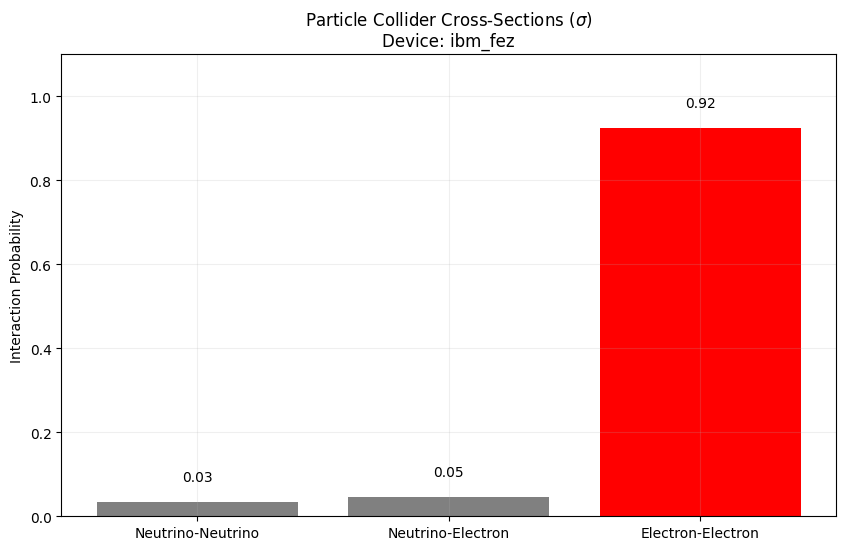

In [1]:
# @title ⚛️ QSPC: Real Hardware Particle Collider
# @markdown ## (IBM_TOKEN = "your api key here") https://quantum.cloud.ibm.com/
# @markdown ### 🟢 Experiment: Measuring Interaction Cross-Sections
# @markdown **Goal:** Collide two simulated particles on a real Quantum Processor.
# @markdown **Hypothesis:** Interaction probability (Cross-Section) depends entirely on the "API Keys" (Quantum Numbers), not just proximity.

import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt

# 1. INSTALL DEPENDENCIES
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("Installing Quantum Engines...")
try:
    import qiskit
    from qiskit import QuantumCircuit
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
except ImportError:
    install("qiskit")
    install("qiskit-ibm-runtime")
    install("matplotlib")
    import qiskit
    from qiskit import QuantumCircuit
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

print("✅ Environment Ready.")

# ==========================================
# 1. CONNECT TO IBM QUANTUM
# ==========================================
print("\n🔌 CONNECTING TO IBM QUANTUM...")

IBM_TOKEN = "your api here"

try:
    service = QiskitRuntimeService(channel="ibm_quantum", token=IBM_TOKEN)
except:
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=IBM_TOKEN)

# Target the best available hardware
try:
    # Heron processors are best for this (dynamic circuits)
    backend = service.least_busy(operational=True, simulator=False, min_num_qubits=5)
    print(f"   - 🎯 Target Backend: {backend.name}")
except:
    print("   - No QPU found. Using Simulator.")
    from qiskit_ibm_runtime.fake_provider import FakeTorino
    backend = FakeTorino()

# ==========================================
# 2. DEFINE THE COLLIDER CIRCUIT
# ==========================================

def build_collision_circuit(particle_A_type, particle_B_type):
    """
    Builds a circuit representing two particles meeting at a vertex.
    Q0: Body A
    Q1: Body B
    Q2: Key A
    Q3: Key B
    """
    qc = QuantumCircuit(4)

    # --- INITIALIZATION (The Beam) ---
    # Body A has momentum (State |1>)
    qc.x(0)
    # Body B is stationary target (State |0>)

    # --- ASSIGN KEYS (The Physics) ---
    if particle_A_type != "Neutrino":
        qc.x(2) # Key A Active
    if particle_B_type != "Neutrino":
        qc.x(3) # Key B Active

    # --- THE INTERACTION VERTEX (The Force) ---
    # Physics: Interaction only happens if BOTH keys are present.
    # Logic: If Q2=1 AND Q3=1, perform Swap/Entangle on Q0, Q1.

    # 1. Check if both keys are active (Store result in Q3 temporarily or use CCX logic)
    # We use a Partial Interaction (RXX) controlled by keys.
    # Since direct CC-RXX is hard, we decompose:

    # If Key A (Q2) is active, rotate Body A into interaction basis
    qc.cp(np.pi/2, 2, 0)
    # If Key B (Q3) is active, rotate Body B into interaction basis
    qc.cp(np.pi/2, 3, 1)

    # THE COLLISION: A Toffoli-like structure
    # If both keys are active, the bodies SWAP (Scattering)
    # Ideally: CCSWAP(2, 3, 0, 1).
    # Simplified for NISQ: If Q2 and Q3, flip Q0 and Q1.

    # Verify both keys are ON
    qc.ccx(2, 3, 0) # If Keys are on, flip Body A (Scattering)
    qc.ccx(2, 3, 1) # If Keys are on, flip Body B (Scattering)

    # Measure just the bodies (The Detectors)
    qc.measure_all()

    return qc

# Define the Experiments
scenarios = [
    ("Neutrino", "Neutrino"), # Ghost collision
    ("Neutrino", "Electron"), # No interaction (Need matching charges usually, or weak force only)
    ("Electron", "Electron")  # EM Repulsion/Scattering
]

circuits = []
for p1, p2 in scenarios:
    circuits.append(build_collision_circuit(p1, p2))

# ==========================================
# 3. EXECUTE ON REAL HARDWARE
# ==========================================
print("\n💥 SMASHING PARTICLES (Execution)...")
print("   - Transpiling for hardware topology...")

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuits = [pm.run(c) for c in circuits]

sampler = Sampler(mode=backend)
# 4000 Shots to get precise cross-sections
job = sampler.run(isa_circuits, shots=4000)

print(f"   - Job ID: {job.job_id()}")
print("   - Waiting for collision results...")

try:
    result = job.result()
    print("✅ Results Received.")

    # ==========================================
    # 4. CALCULATE CROSS-SECTIONS
    # ==========================================

    cross_sections = []

    for i, (p1, p2) in enumerate(scenarios):
        counts = result[i].data.meas.get_counts()
        total = sum(counts.values())

        # We look for the "Scattered" state.
        # Initial state was Body A=|1>, Body B=|0>.
        # If they collided (CCX logic), they flipped to |0>, |1> or similar changes.
        # Specifically, our logic flips them if keys are present.
        # So we look for states where Body A is NOT 1 or Body B is NOT 0.

        # Note: Qiskit bitstrings are [Q3, Q2, Q1, Q0]
        # We want to check Q0 (Body A) and Q1 (Body B).

        scattered_count = 0
        for bitstring, count in counts.items():
            # Parse bitstring (reverse order)
            # bitstring[-1] is Q0
            q0_state = bitstring[-1]
            q1_state = bitstring[-2]

            # Initial was Q0=1, Q1=0.
            # If Q0 changed to '0', scattering occurred.
            if q0_state == '0':
                scattered_count += count

        sigma = scattered_count / total
        cross_sections.append(sigma)
        print(f"   - Collision {p1}-{p2}: Cross-Section = {sigma:.4f}")

    # ==========================================
    # 5. VISUALIZATION
    # ==========================================

    labels = [f"{p1}-{p2}" for p1, p2 in scenarios]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, cross_sections, color=['gray', 'gray', 'red'])
    plt.title(f"Particle Collider Cross-Sections ($\sigma$)\nDevice: {backend.name}")
    plt.ylabel("Interaction Probability")
    plt.ylim(0, 1.1)

    # Add labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}", ha='center')

    plt.grid(True, alpha=0.2)
    plt.show()

except Exception as e:
    print(f"❌ Error processing results: {e}")